# External data validation - Sanger dataset

In [78]:
import ast
import pandas as pd

from collections import namedtuple

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, plot_confusion_matrix, roc_auc_score, plot_roc_curve, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import yellowbrick.model_selection as ybms
from yellowbrick.classifier import precision_recall_curve

import sys
sys.path.append('../')
from utils.cv_helpers import *

In [2]:
with open('../her2-status_config.json', 'r') as f:
    config = ast.literal_eval(f.read())

In [3]:
cv_scheme = RepeatedStratifiedKFold(n_splits=config['FOLDS'], n_repeats=config['REPEATS'], random_state=config['SEED'])

scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'Kappa': make_scorer(cohen_kappa_score),
    'MCC': make_scorer(matthews_corrcoef),
    'LL': make_scorer(log_loss),
    'F1': make_scorer(f1_score),
    'AUC': make_scorer(roc_auc_score)
}

class_weight = {1:7, 0:1}

In [4]:
X = pd.read_csv(config['TRAIN_DATA_FILE']).drop(['Tumour Average Depth', 'Normal Average Depth'], axis=1).set_index('sample_id')
y = pd.read_csv(config['Y_TRAIN_FILE']).set_index('sample_id').Class

In [5]:
X_holdout = pd.read_csv(config['HOLDOUT_DATA_FILE']).set_index('sample_id')
X_holdout = X_holdout.drop(['Tumour Average Depth', 'Normal Average Depth'], axis=1)
y_holdout = pd.read_csv(config['Y_HOLDOUT_FILE']).set_index('sample_id').Class

In [25]:
clf = DecisionTreeClassifier(ccp_alpha=0.01, class_weight='balanced', max_depth=1, min_samples_leaf=1, min_samples_split=2)

model = clf.fit(X.append(X_holdout), y.append(y_holdout))

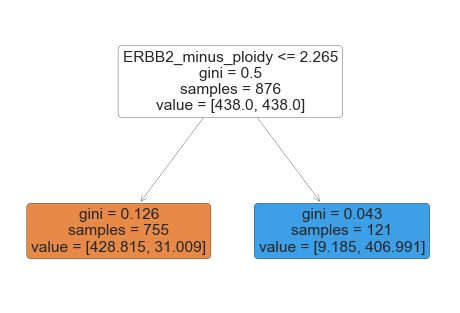

In [26]:
plot_tree(model,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          proportion=False
);

In [46]:
data_sanger = pd.read_excel('../data/sanger dataset.xlsx').set_index('sample_id')

dataset_sanger = data_sanger[[*X.columns, 'IHC HER2']].dropna()

X_sanger = dataset_sanger[X.columns]
y_sanger = dataset_sanger['IHC HER2']

In [47]:
y_sanger_pred = model.predict(X_sanger)
y_sanger_prob = model.predict_proba(X_sanger)

In [79]:
print(f'AUROC: {roc_auc_score(y_sanger, y_sanger_prob[:, 1])}')
print(f'Accuracy: {accuracy_score(y_sanger, y_sanger_pred)}')
print(f'Balanced accuracy: {balanced_accuracy_score(y_sanger, y_sanger_pred)}')
print(f'Cohen\'s kappa: {cohen_kappa_score(y_sanger, y_sanger_pred)}')
print(f'MCC: {matthews_corrcoef(y_sanger, y_sanger_pred)}')
print(f'Precision: {precision_score(y_sanger, y_sanger_pred)}')
print(f'Recall: {recall_score(y_sanger, y_sanger_pred)}')
print(f'F1: {f1_score(y_sanger, y_sanger_pred)}')

AUROC: 0.9295658187503758
Accuracy: 0.9528130671506352
Balanced accuracy: 0.9295658187503759
Cohen's kappa: 0.7995578688157601
MCC: 0.8030014662677675
Precision: 0.7654320987654321
Recall: 0.8985507246376812
F1: 0.8266666666666668
